### Import libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import email
import string
import nltk
nltk.download('omw-1.4')
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn import datasets
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support as p_r_f1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re

#import warnings
#warnings.filterwarnings("ignore")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/navneetparab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Load the dataset

In [ ]:
df = pd.read_csv('Suicide_Detection.csv')

In [ ]:
df.info()

In [2]:
def remove_punctuations(text):
    for char in string.punctuation:
        text = text.replace(char, ' ')
    return text

In [3]:
def data_preprocessing(dataframe):
    # Dropping redundant columns
    dataframe.drop(columns=['Unnamed: 0'], inplace=True)
    
    # Keeping only latin alphabets and numbers
    dataframe['text'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
    
    # Remove punctuation
    dataframe['text'] = dataframe['text'].apply(remove_punctuations)
    
    # Remove stopwords
    stop = stopwords.words('english')
    extra_stop = stop + ['ive', 'im', 'youre', 'youve', 'youll', 'youd', 'shes', 'arent', 'couldnt', 'didnt', 'doesnt', 'hadnt', 'hasnt', 'havent', 'isnt', 'shouldnt', 'wasnt', 'werent', 'wont', 'wouldnt', 'http', 'filler', 'pog', 'auto','webp', 'redd', 'http', 'https', 'preview', 'amp']
    
    dataframe['text'] = dataframe['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in extra_stop]))
    
    # Remove numeric strings
    dataframe['text'] = dataframe['text'].str.replace('\d+', '')
    
    #Tokenize
    dataframe['text'] = dataframe.apply(lambda row: word_tokenize(row['text']), axis=1)
    
    # Remove non English words
    eng_words = set(words.words())
    dataframe['text'] = dataframe['text'].apply(lambda row: [word for word in row if word in eng_words or not word.isalpha()])
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    dataframe['text'] = dataframe['text'].apply(lambda row : [lemmatizer.lemmatize(i) for i in row])
    
    # Convert list to string
    dataframe['text'] = [','.join(map(str, l)) for l in dataframe['text']]
    
    # Rename columns
    dataframe.rename(columns={'text': 'body'}, inplace=True)
    dataframe.rename(columns={'class': 'Label'}, inplace=True)
    
    return dataframe   

### Cleaning data and saving as a csv file

In [ ]:
data = data_preprocessing(df)
data.to_csv('clean_dataset.csv')

### Reading from cleaned data csv

In [2]:
data = pd.read_csv('clean_dataset.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

### Creating two datasets: Entire and Sampled

In [3]:
sampled_data=data.sample(frac=0.2,random_state=222)
sampled_data.reset_index(inplace=True)
sampled_data.drop(columns = ['index'], inplace=True)

#### Targets for Entire and sampled datasets

In [4]:
targets = data['Label'].values
sampled_targets = sampled_data['Label'].values

# Sampled Data Training and Testing Section

## Using Sampled data for hyperparameter selection

### Count Vectorizer

In [5]:
# Unigrams
samp_count_vectorizer_1 = CountVectorizer(ngram_range=(1,1))
samp_count_matrix_1 = samp_count_vectorizer_1.fit_transform(sampled_data['body'].values.astype('U'))

# Bigrams
samp_count_vectorizer_2 = CountVectorizer(ngram_range=(1,2))
samp_count_matrix_2 = samp_count_vectorizer_2.fit_transform(sampled_data['body'].values.astype('U'))

### TF-IDF

In [6]:
# Unigrams
samp_tfidf_vectorizer_1 = TfidfVectorizer(ngram_range=(1,1))
samp_tfidf_matrix_1 = samp_tfidf_vectorizer_1.fit_transform(sampled_data['body'].values.astype('U'))

# Bigrams
samp_tfidf_vectorizer_2 = TfidfVectorizer(ngram_range=(1,2))
samp_tfidf_matrix_2 = samp_tfidf_vectorizer_2.fit_transform(sampled_data['body'].values.astype('U'))

## Grid Search Cross Validation

In [5]:
# Train and evaluate the Logistic Regression classifier
def train_lr(X_train, y_train, X_test, y_test):
    model = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)
    params = {'C': [0.1, 1, 5]}
    clf = GridSearchCV(model, params, cv=5, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('\nLogistic Regression Results:')
    print('Best Parameters:', clf.best_params_)
    print('\nAccuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, pos_label='suicide'))
    print('Recall:', recall_score(y_test, y_pred, pos_label='suicide'))
    print('F1 Score:', f1_score(y_test, y_pred, pos_label='suicide'))

In [6]:
# Train and evaluate the Support Vector Machine classifier
def train_svm(X_train, y_train, X_test, y_test, dual_value):
    model = LinearSVC(dual=dual_value)
    params = {'C': [0.1, 0.5, 1, 5]}
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('\nSupport Vector Machine Results:')
    print('Best Parameters:', clf.best_params_)
    print('\nAccuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, pos_label='suicide'))
    print('Recall:', recall_score(y_test, y_pred, pos_label='suicide'))
    print('F1 Score:', f1_score(y_test, y_pred, pos_label='suicide'))      

In [7]:
# Train and evaluate the Naïve Bayes classifier    
def train_naive_bayes(X_train, y_train, X_test, y_test):
    model = MultinomialNB()
    params = {'alpha': [0.001, 0.01, 0.1, 1]}
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('\nNaive Bayes Results:')
    print('Best Parameters:', clf.best_params_)
    print('\nAccuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, pos_label='suicide'))
    print('Recall:', recall_score(y_test, y_pred, pos_label='suicide'))
    print('F1 Score:', f1_score(y_test, y_pred, pos_label='suicide'))

In [8]:
# Train and evaluate the K-Nearest Neighbors classifier
def train_knn(X_train, y_train, X_test, y_test):
    model = KNeighborsClassifier()
    params = {'n_neighbors': [3, 5, 10]}
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('\nK-Nearest Neighbors Results:')
    print('Best Parameters:', clf.best_params_)
    print('\nAccuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, pos_label='suicide'))
    print('Recall:', recall_score(y_test, y_pred, pos_label='suicide'))
    print('F1 Score:', f1_score(y_test, y_pred, pos_label='suicide'))

# Count Unigrams

In [11]:
X_train, X_test, y_train, y_test = train_test_split(samp_count_matrix_1, sampled_targets, test_size=0.2, random_state=22)

In [ ]:
train_lr(X_train,y_train,X_test,y_test) 

In [ ]:
train_svm(X_train,y_train,X_test,y_test, dual_value=False) # n_samples > n_features

In [ ]:
train_naive_bayes(X_train,y_train,X_test,y_test)

In [ ]:
train_knn(X_train,y_train,X_test,y_test)

# Count Bigrams

In [11]:
X_train, X_test, y_train, y_test = train_test_split(samp_count_matrix_2, sampled_targets, test_size=0.2, random_state=22)

In [ ]:
train_lr(X_train,y_train,X_test,y_test)

In [ ]:
train_svm(X_train,y_train,X_test,y_test, dual_value=True) # n_samples < n_features

In [ ]:
train_naive_bayes(X_train,y_train,X_test,y_test)

In [ ]:
train_knn(X_train,y_train,X_test,y_test)

# TF-IDF Unigrams

In [11]:
X_train, X_test, y_train, y_test = train_test_split(samp_tfidf_matrix_1, sampled_targets, test_size=0.2, random_state=22)

In [ ]:
train_lr(X_train,y_train,X_test,y_test)

In [ ]:
train_svm(X_train,y_train,X_test,y_test, dual_value=False) # n_samples > n_features

In [ ]:
train_naive_bayes(X_train,y_train,X_test,y_test)

In [ ]:
train_knn(X_train,y_train,X_test,y_test)

# TF-IDF Bigrams

In [11]:
X_train, X_test, y_train, y_test = train_test_split(samp_tfidf_matrix_2, sampled_targets, test_size=0.2, random_state=22)

In [ ]:
train_lr(X_train,y_train,X_test,y_test)

In [ ]:
train_svm(X_train,y_train,X_test,y_test, dual_value=True) # n_samples < n_features

In [ ]:
train_naive_bayes(X_train,y_train,X_test,y_test)

In [ ]:
train_knn(X_train,y_train,X_test,y_test)

# After hyperparameter selection

We reject KNN algorithm and the Count Vectorization method

## Unigrams 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(samp_tfidf_matrix_1, sampled_targets, test_size=0.2, random_state=22)

### Logistic Regression (C = 1)

In [27]:
lr = LogisticRegression(C=1, penalty='l1', solver='saga')
lr.fit(X_train, y_train)
lr_pred_train = lr.predict(X_train)
lr_pred_test = lr.predict(X_test)
lr_train_report = classification_report(y_train, lr_pred_train)
lr_test_report = classification_report(y_test, lr_pred_test)

In [28]:
# print the confusion matrix and classification report for each classifier on the training and test sets
print('For Sampled Dataset (TFIDF - unigrams)')
print('Logistic Regression confusion matrix (training set):\n', confusion_matrix(y_train, lr_pred_train))
print('Logistic Regression classification report (training set):\n', lr_train_report)
print('Logistic Regression confusion matrix (test set):\n', confusion_matrix(y_test, lr_pred_test))
print('Logistic Regression classification report (test set):\n', lr_test_report)

For Sampled Dataset (TFIDF - unigrams)
Logistic Regression confusion matrix (training set):
 [[17353  1167]
 [ 1768 16844]]
Logistic Regression classification report (training set):
               precision    recall  f1-score   support

 non-suicide       0.91      0.94      0.92     18520
     suicide       0.94      0.91      0.92     18612

    accuracy                           0.92     37132
   macro avg       0.92      0.92      0.92     37132
weighted avg       0.92      0.92      0.92     37132

Logistic Regression confusion matrix (test set):
 [[4343  313]
 [ 521 4106]]
Logistic Regression classification report (test set):
               precision    recall  f1-score   support

 non-suicide       0.89      0.93      0.91      4656
     suicide       0.93      0.89      0.91      4627

    accuracy                           0.91      9283
   macro avg       0.91      0.91      0.91      9283
weighted avg       0.91      0.91      0.91      9283



### Support Vector Machines (C = 0.5)

In [17]:
SVM = LinearSVC(C=0.5, dual=False) #n_samples > n_features
SVM.fit(X_train, y_train)
svm_pred_train = SVM.predict(X_train)
svm_pred_test = SVM.predict(X_test)
svm_train_report = classification_report(y_train, svm_pred_train)
svm_test_report = classification_report(y_test, svm_pred_test)

In [18]:
print('For Sampled Dataset (TFIDF - unigrams)')
print('Support Vector Machine confusion matrix (training set):\n', confusion_matrix(y_train, svm_pred_train))
print('Support Vector Machine classification report (training set):\n', svm_train_report)
print('Support Vector Machine confusion matrix (test set):\n', confusion_matrix(y_test, svm_pred_test))
print('Support Vector Machine classification report (test set):\n', svm_test_report)

For Sampled Dataset (TFIDF - unigrams)
Support Vector Machine confusion matrix (training set):
 [[17659   861]
 [ 1149 17463]]
Support Vector Machine classification report (training set):
               precision    recall  f1-score   support

 non-suicide       0.94      0.95      0.95     18520
     suicide       0.95      0.94      0.95     18612

    accuracy                           0.95     37132
   macro avg       0.95      0.95      0.95     37132
weighted avg       0.95      0.95      0.95     37132

Support Vector Machine confusion matrix (test set):
 [[4343  313]
 [ 513 4114]]
Support Vector Machine classification report (test set):
               precision    recall  f1-score   support

 non-suicide       0.89      0.93      0.91      4656
     suicide       0.93      0.89      0.91      4627

    accuracy                           0.91      9283
   macro avg       0.91      0.91      0.91      9283
weighted avg       0.91      0.91      0.91      9283



### Naïve Bayes (alpha = 0.1)

In [19]:
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train, y_train)
nb_pred_train = nb.predict(X_train)
nb_pred_test = nb.predict(X_test)
nb_train_report = classification_report(y_train, nb_pred_train)
nb_test_report = classification_report(y_test, nb_pred_test)

In [20]:
print('For Sampled Dataset (TFIDF - unigrams)')
print('Naive Bayes confusion matrix (training set):\n', confusion_matrix(y_train, nb_pred_train))
print('Naive Bayes classification report (training set):\n', nb_train_report)
print('Naive Bayes confusion matrix (test set):\n', confusion_matrix(y_test, nb_pred_test))
print('Naive Bayes classification report (test set):\n', nb_test_report)

For Sampled Dataset (TFIDF - unigrams)
Naive Bayes confusion matrix (training set):
 [[15543  2977]
 [  875 17737]]
Naive Bayes classification report (training set):
               precision    recall  f1-score   support

 non-suicide       0.95      0.84      0.89     18520
     suicide       0.86      0.95      0.90     18612

    accuracy                           0.90     37132
   macro avg       0.90      0.90      0.90     37132
weighted avg       0.90      0.90      0.90     37132

Naive Bayes confusion matrix (test set):
 [[3741  915]
 [ 293 4334]]
Naive Bayes classification report (test set):
               precision    recall  f1-score   support

 non-suicide       0.93      0.80      0.86      4656
     suicide       0.83      0.94      0.88      4627

    accuracy                           0.87      9283
   macro avg       0.88      0.87      0.87      9283
weighted avg       0.88      0.87      0.87      9283



## Bigrams 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(samp_tfidf_matrix_2, sampled_targets, test_size=0.2, random_state=22)

### Logistic Regression (C = 5)

In [30]:
lr = LogisticRegression(C=5, penalty='l1', solver='saga')
lr.fit(X_train, y_train)
lr_pred_train = lr.predict(X_train)
lr_pred_test = lr.predict(X_test)
lr_train_report = classification_report(y_train, lr_pred_train)
lr_test_report = classification_report(y_test, lr_pred_test)

/Users/navneetparab/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [31]:
# print the confusion matrix and classification report for each classifier on the training and test sets
print('For Sampled Dataset (TFIDF - bigrams)')
print('Logistic Regression confusion matrix (training set):\n', confusion_matrix(y_train, lr_pred_train))
print('Logistic Regression classification report (training set):\n', lr_train_report)
print('Logistic Regression confusion matrix (test set):\n', confusion_matrix(y_test, lr_pred_test))
print('Logistic Regression classification report (test set):\n', lr_test_report)

For Sampled Dataset (TFIDF - bigrams)
Logistic Regression confusion matrix (training set):
 [[17924   596]
 [  739 17873]]
Logistic Regression classification report (training set):
               precision    recall  f1-score   support

 non-suicide       0.96      0.97      0.96     18520
     suicide       0.97      0.96      0.96     18612

    accuracy                           0.96     37132
   macro avg       0.96      0.96      0.96     37132
weighted avg       0.96      0.96      0.96     37132

Logistic Regression confusion matrix (test set):
 [[4355  301]
 [ 498 4129]]
Logistic Regression classification report (test set):
               precision    recall  f1-score   support

 non-suicide       0.90      0.94      0.92      4656
     suicide       0.93      0.89      0.91      4627

    accuracy                           0.91      9283
   macro avg       0.91      0.91      0.91      9283
weighted avg       0.91      0.91      0.91      9283



### Support Vector Machines (C = 0.5)

In [22]:
SVM = LinearSVC(C=1, dual=True) #n_samples < n_features
SVM.fit(X_train, y_train)
svm_pred_train = SVM.predict(X_train)
svm_pred_test = SVM.predict(X_test)
svm_train_report = classification_report(y_train, svm_pred_train)
svm_test_report = classification_report(y_test, svm_pred_test)

In [23]:
print('For Sampled Dataset (TFIDF - bigrams)')
print('Support Vector Machine confusion matrix (training set):\n', confusion_matrix(y_train, svm_pred_train))
print('Support Vector Machine classification report (training set):\n', svm_train_report)
print('Support Vector Machine confusion matrix (test set):\n', confusion_matrix(y_test, svm_pred_test))
print('Support Vector Machine classification report (test set):\n', svm_test_report)

For Sampled Dataset (TFIDF - bigrams)
Support Vector Machine confusion matrix (training set):
 [[18458    62]
 [   75 18537]]
Support Vector Machine classification report (training set):
               precision    recall  f1-score   support

 non-suicide       1.00      1.00      1.00     18520
     suicide       1.00      1.00      1.00     18612

    accuracy                           1.00     37132
   macro avg       1.00      1.00      1.00     37132
weighted avg       1.00      1.00      1.00     37132

Support Vector Machine confusion matrix (test set):
 [[4368  288]
 [ 508 4119]]
Support Vector Machine classification report (test set):
               precision    recall  f1-score   support

 non-suicide       0.90      0.94      0.92      4656
     suicide       0.93      0.89      0.91      4627

    accuracy                           0.91      9283
   macro avg       0.92      0.91      0.91      9283
weighted avg       0.92      0.91      0.91      9283



### Naïve Bayes (alpha = 0.01)

In [24]:
nb = MultinomialNB(alpha=0.01)
nb.fit(X_train, y_train)
nb_pred_train = nb.predict(X_train)
nb_pred_test = nb.predict(X_test)
nb_train_report = classification_report(y_train, nb_pred_train)
nb_test_report = classification_report(y_test, nb_pred_test)

In [25]:
print('For Sampled Dataset (TFIDF - bigrams)')
print('Naive Bayes confusion matrix (training set):\n', confusion_matrix(y_train, nb_pred_train))
print('Naive Bayes classification report (training set):\n', nb_train_report)
print('Naive Bayes confusion matrix (test set):\n', confusion_matrix(y_test, nb_pred_test))
print('Naive Bayes classification report (test set):\n', nb_test_report)

For Sampled Dataset (TFIDF - bigrams)
Naive Bayes confusion matrix (training set):
 [[18167   353]
 [   74 18538]]
Naive Bayes classification report (training set):
               precision    recall  f1-score   support

 non-suicide       1.00      0.98      0.99     18520
     suicide       0.98      1.00      0.99     18612

    accuracy                           0.99     37132
   macro avg       0.99      0.99      0.99     37132
weighted avg       0.99      0.99      0.99     37132

Naive Bayes confusion matrix (test set):
 [[3706  950]
 [ 272 4355]]
Naive Bayes classification report (test set):
               precision    recall  f1-score   support

 non-suicide       0.93      0.80      0.86      4656
     suicide       0.82      0.94      0.88      4627

    accuracy                           0.87      9283
   macro avg       0.88      0.87      0.87      9283
weighted avg       0.88      0.87      0.87      9283



# Training and Testing with stratified k folds

In [15]:
# Training and Testing with Stratified k Folds
def model_performance(folds, data_frame, targets, vectorizer, classifier):

    precision_list_train = []
    precision_list_test = []
    recall_list_train = []
    recall_list_test = []
    f1_list_train = []
    f1_list_test = []
    
    # Fold data in K folds maintaining balanced spam and non-spam emails in training
    skf = StratifiedKFold(n_splits=folds, shuffle=True)

    for train_index, test_index in skf.split(data_frame, targets):
        # Split into test and train
        X_train, X_test = data_frame['body'][train_index].values.astype('U'), data_frame['body'][test_index].values.astype('U')
        y_train, y_test = targets[train_index], targets[test_index]
        
        # Transformation and Fit
        X_vect = vectorizer.fit_transform(X_train)
        classifier.fit(X_vect, y_train)
        X_test_vect = vectorizer.transform(X_test)
        y_predict_train = classifier.predict(X_vect)
        y_predict_test = classifier.predict(X_test_vect)
        
        # Confusion matrix, Precision, Recall and F1 Score
        confusion_train = confusion_matrix(y_train, y_predict_train, labels=classifier.classes_)
        confusion_test = confusion_matrix(y_test, y_predict_test, labels=classifier.classes_)
        
        precision_recall_f1score_train = p_r_f1(y_train, y_predict_train, labels=classifier.classes_, average='binary', pos_label='suicide')
        precision_recall_f1score_test = p_r_f1(y_test, y_predict_test, labels=classifier.classes_, average='binary', pos_label='suicide')
        
        # Precision list
        precision_value_train = precision_recall_f1score_train[0]
        precision_list_train.append(precision_value_train)
        precision_value_test = precision_recall_f1score_test[0]
        precision_list_test.append(precision_value_test)
        
        # Recall list
        recall_value_train = precision_recall_f1score_train[1]
        recall_list_train.append(recall_value_train)
        recall_value_test = precision_recall_f1score_test[1]
        recall_list_test.append(recall_value_test)
        
        # F1 Score list
        f1_value_train = precision_recall_f1score_train[2]
        f1_list_train.append(f1_value_train)
        f1_value_test = precision_recall_f1score_test[2]
        f1_list_test.append(f1_value_test)
    
    # Storing all metrics and confusion matrix
    score_train = avg_score(precision_list_train, recall_list_train, f1_list_train)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=confusion_train, display_labels=classifier.classes_)
    score_test = avg_score(precision_list_test, recall_list_test, f1_list_test)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_test, display_labels=classifier.classes_)
     
    return score_train, disp_train, score_test, disp_test

In [16]:
# Average values for Precision, Recall and F1 Score
def avg_score(precision_list, recall_list, f1_list):
    
    avg_precision = np.mean(precision_list, axis = 0)
    avg_recall = np.mean(recall_list, axis = 0)
    avg_f1 = np.mean(f1_list, axis = 0)
    
    return avg_precision, avg_recall, avg_f1

In [17]:
def display_score(score):
        print('Average score of 5 folds :','\n'\
          '\t Precision: \t {:.3f}'.format(score[0]),'\n' \
          '\t Recall: \t {:.3f}'.format(score[1]),'\n' \
          '\t F-1 Score: \t {:.3f}'.format(score[2]),'\n')

In [18]:
def learning_curve(data_frame, targets, vectorizer, classifier):
    folds_list = np.arange(10, 1, -1)
    precision_list =[]
    recall_list = []
    f1_scores_list = []
    
    for fold in folds_list:
        test_score = model_performance(fold, data_frame, targets, vectorizer, classifier)[2];
        precision_list.append(test_score[0])
        recall_list.append(test_score[1])
        f1_scores_list.append(test_score[2])
        
    plt.plot(100/folds_list, precision_list, label = 'Precision')    
    plt.plot(100/folds_list, recall_list, label = 'Recall')    
    plt.plot(100/folds_list, f1_scores_list, label = 'F1 Score')
    plt.xlabel('Training set size (in %)')
    plt.ylabel('Score')
    plt.legend()

## Unigrams 

In [38]:
LogisticRegression_L1_c_1=LogisticRegression(penalty='l1', C = 1, solver='saga', max_iter=1000)
svm_05 = LinearSVC(C=0.5, dual=False) #n_samples > n_features
naive_bayes_01 = MultinomialNB(alpha=0.1)

In [39]:
df_scores = pd.DataFrame(index=['Precision', 'Recall', 'F1 Score'])

For Sampled Dataset (TFIDF - unigrams)
Logistic Regression L1 regularization (C = 1) tfidf vectorized 


Training
Average score of 5 folds : 
	 Precision: 	 0.935 
	 Recall: 	 0.904 
	 F-1 Score: 	 0.920 


Testing
Average score of 5 folds : 
	 Precision: 	 0.925 
	 Recall: 	 0.892 
	 F-1 Score: 	 0.909 



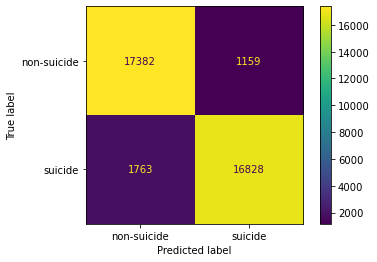

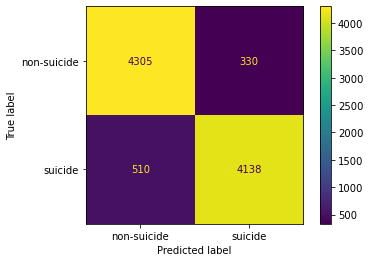

In [40]:
print('For Sampled Dataset (TFIDF - unigrams)')
print("Logistic Regression L1 regularization (C = 1) tfidf vectorized \n")
train_score, train_plot, test_score, test_plot = model_performance(5, sampled_data, sampled_targets, samp_tfidf_vectorizer_1, LogisticRegression_L1_c_1)
df_scores['Logistic Regression (L1, C = 1) Training'] = list(train_score)
df_scores['Logistic Regression (L1, C = 1)'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

For Sampled Dataset (TFIDF - unigrams)
Support Vector Machine (C = 0.5) tfidf vectorized 

Training
Average score of 5 folds : 
	 Precision: 	 0.952 
	 Recall: 	 0.938 
	 F-1 Score: 	 0.945 


Testing
Average score of 5 folds : 
	 Precision: 	 0.925 
	 Recall: 	 0.898 
	 F-1 Score: 	 0.911 



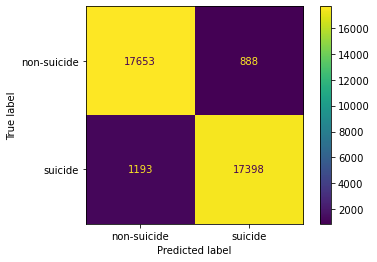

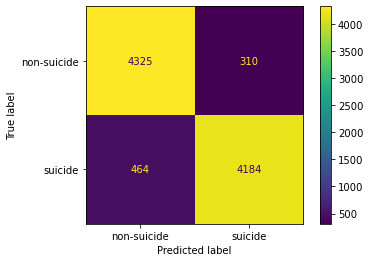

In [41]:
print('For Sampled Dataset (TFIDF - unigrams)')
print("Support Vector Machine (C = 0.5) tfidf vectorized ")
train_score, train_plot, test_score, test_plot = model_performance(5, sampled_data, sampled_targets, samp_tfidf_vectorizer_1, svm_05)
df_scores['Support Vector Machine (C = 0.5) Training'] = list(train_score)
df_scores['Support Vector Machine (C = 0.5) Testing'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

For Sampled Dataset (TFIDF - unigrams)
Naive Bayes (alpha = 0.1) tfidf vectorized 

Training
Average score of 5 folds : 
	 Precision: 	 0.855 
	 Recall: 	 0.953 
	 F-1 Score: 	 0.901 


Testing
Average score of 5 folds : 
	 Precision: 	 0.822 
	 Recall: 	 0.941 
	 F-1 Score: 	 0.878 



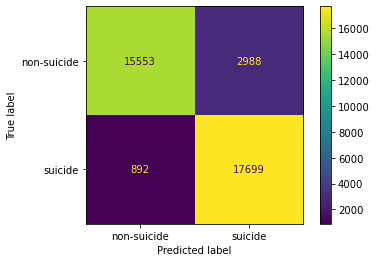

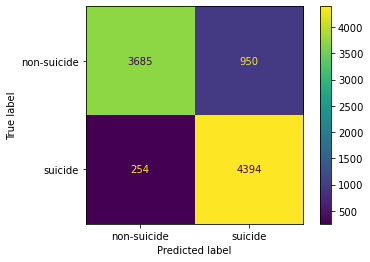

In [43]:
print('For Sampled Dataset (TFIDF - unigrams)')
print("Naive Bayes (alpha = 0.1) tfidf vectorized ")
train_score, train_plot, test_score, test_plot = model_performance(5, sampled_data, sampled_targets, samp_tfidf_vectorizer_1, naive_bayes_01)
df_scores['Naive Bayes (alpha = 0.1) Training'] = list(train_score)
df_scores['Naive Bayes (alpha = 0.1) Testing'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

In [44]:
df_scores

,"Logistic Regression (L1, C = 1) Training","Logistic Regression (L1, C = 1)",Support Vector Machine (C = 0.5) Training,Support Vector Machine (C = 0.5) Testing,Naive Bayes (alpha = 0.1) Training,Naive Bayes (alpha = 0.1) Testing
Precision,0.935150,0.925268,0.952418,0.924631,0.855233,0.822170
Recall,0.904396,0.892422,0.937777,0.897758,0.952838,0.941176
F1 Score,0.919515,0.908545,0.945041,0.910991,0.901400,0.877654


### Learning Curves

#### Logistic Regression

In [ ]:
learning_curve(sampled_data, sampled_targets, samp_tfidf_vectorizer_1, LogisticRegression_L1_c_1)

#### Support Vector Machine

In [ ]:
learning_curve(sampled_data, sampled_targets, samp_tfidf_vectorizer_1, svm_05)

#### Naïve Bayes

In [ ]:
learning_curve(sampled_data, sampled_targets, samp_tfidf_vectorizer_1, naive_bayes_01)


### Tokens

In [50]:
# get the probabilities of each token given that the email is spam and ham
p_risk = naive_bayes_01.feature_log_prob_[0, :]
p_no_risk = naive_bayes_01.feature_log_prob_[1, :]

# calculate the log-ratio of the probabilities for each token
log_ratio = np.log(p_risk / p_no_risk)

# get the feature names from the TF-IDF vectorizer
feature_names = samp_tfidf_vectorizer_1.get_feature_names_out()

# sort the tokens based on the log-ratio in descending order
sorted_indices = np.argsort(log_ratio)[::-1]

# print the 10 most indicative tokens for the spam class
for i in range(10):
    token_index = sorted_indices[i]
    token_log_ratio = log_ratio[token_index]
    token_name = feature_names[token_index]
    print(f"{i+1}. {token_name} ({token_log_ratio:.2f})")

1. ideation (0.40)
2. inpatient (0.40)
3. overdose (0.39)
4. suicide (0.38)
5. painless (0.38)
6. prescription (0.38)
7. retarded (0.37)
8. suicidal (0.37)
9. noose (0.36)
10. jobless (0.34)


## Bigrams 

In [51]:
LogisticRegression_L1_c_5=LogisticRegression(penalty='l1', C = 5, solver='saga', max_iter=1000)
svm_1 = LinearSVC(C=1, dual=True) #n_samples < n_features
naive_bayes_001 = MultinomialNB(alpha=0.01)

In [52]:
df_scores = pd.DataFrame(index=['Precision', 'Recall', 'F1 Score'])

For Sampled Dataset (TFIDF - bigrams)
Logistic Regression L1 regularization (C = 5) tfidf vectorized 



/Users/navneetparab/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/navneetparab/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/navneetparab/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/navneetparab/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/navneetparab/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Training
Average score of 5 folds : 
	 Precision: 	 0.969 
	 Recall: 	 0.963 
	 F-1 Score: 	 0.966 


Testing
Average score of 5 folds : 
	 Precision: 	 0.904 
	 Recall: 	 0.918 
	 F-1 Score: 	 0.911 



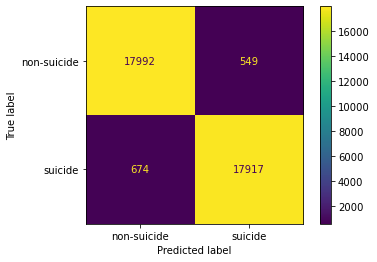

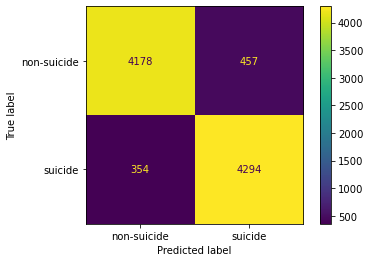

In [53]:
print('For Sampled Dataset (TFIDF - bigrams)')
print("Logistic Regression L1 regularization (C = 5) tfidf vectorized \n")
train_score, train_plot, test_score, test_plot = model_performance(5, sampled_data, sampled_targets, samp_tfidf_vectorizer_2, LogisticRegression_L1_c_5)
df_scores['Logistic Regression (L1, C = 5) Training'] = list(train_score)
df_scores['Logistic Regression (L1, C = 5)'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

For Sampled Dataset (TFIDF - bigrams)
Support Vector Machine (C = 1) tfidf vectorized 

Training
Average score of 5 folds : 
	 Precision: 	 0.996 
	 Recall: 	 0.996 
	 F-1 Score: 	 0.996 


Testing
Average score of 5 folds : 
	 Precision: 	 0.912 
	 Recall: 	 0.920 
	 F-1 Score: 	 0.916 



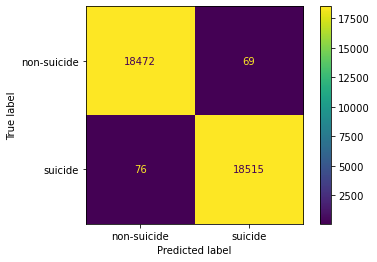

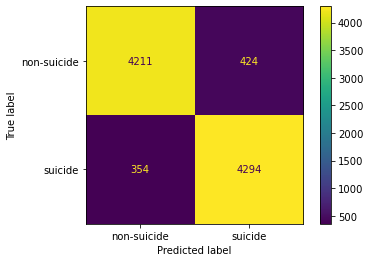

In [54]:
print('For Sampled Dataset (TFIDF - bigrams)')
print("Support Vector Machine (C = 1) tfidf vectorized ")
train_score, train_plot, test_score, test_plot = model_performance(5, sampled_data, sampled_targets, samp_tfidf_vectorizer_2, svm_1)
df_scores['Support Vector Machine (C = 1) Training'] = list(train_score)
df_scores['Support Vector Machine (C = 1) Testing'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

For Sampled Dataset (TFIDF - bigrams)
Naive Bayes (alpha = 0.01) tfidf vectorized 

Training
Average score of 5 folds : 
	 Precision: 	 0.981 
	 Recall: 	 0.996 
	 F-1 Score: 	 0.988 


Testing
Average score of 5 folds : 
	 Precision: 	 0.756 
	 Recall: 	 0.972 
	 F-1 Score: 	 0.851 



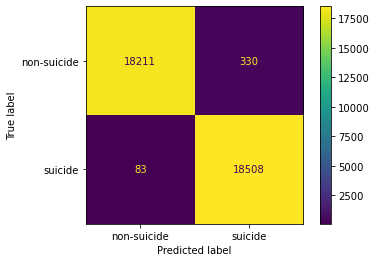

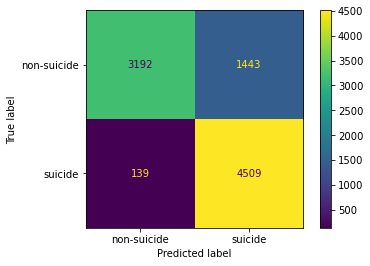

In [56]:
print('For Sampled Dataset (TFIDF - bigrams)')
print("Naive Bayes (alpha = 0.01) tfidf vectorized ")
train_score, train_plot, test_score, test_plot = model_performance(5, sampled_data, sampled_targets, samp_tfidf_vectorizer_2, naive_bayes_001)
df_scores['Naive Bayes (alpha = 0.01) Training'] = list(train_score)
df_scores['Naive Bayes (alpha = 0.01) Testing'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

In [57]:
df_scores

,"Logistic Regression (L1, C = 5) Training","Logistic Regression (L1, C = 5)",Support Vector Machine (C = 1) Training,Support Vector Machine (C = 1) Testing,Naive Bayes (alpha = 0.01) Training,Naive Bayes (alpha = 0.01) Testing
Precision,0.968957,0.903820,0.996438,0.911986,0.980633,0.756337
Recall,0.962692,0.917768,0.996116,0.919575,0.995686,0.972202
F1 Score,0.965814,0.910733,0.996277,0.915752,0.988102,0.850786


### Learning Curves

#### Logistic Regression

In [ ]:
learning_curve(sampled_data, sampled_targets, samp_tfidf_vectorizer_2, LogisticRegression_L1_c_5)

#### Support Vector Machine

In [ ]:
learning_curve(sampled_data, sampled_targets, samp_tfidf_vectorizer_2, svm_1)

#### Naïve Bayes

In [ ]:
learning_curve(sampled_data, sampled_targets, samp_tfidf_vectorizer_2, naive_bayes_001)


### Tokens

In [58]:
p_risk = naive_bayes_001.feature_log_prob_[0, :]
p_no_risk = naive_bayes_001.feature_log_prob_[1, :]

log_ratio = np.log(p_risk / p_no_risk)
feature_names = samp_tfidf_vectorizer_2.get_feature_names_out()

sorted_indices = np.argsort(log_ratio)[::-1]

for i in range(10):
    token_index = sorted_indices[i]
    token_log_ratio = log_ratio[token_index]
    token_name = feature_names[token_index]
    print(f"{i+1}. {token_name} ({token_log_ratio:.2f})")

1. think suicide (0.53)
2. psych ward (0.51)
3. feeling suicidal (0.50)
4. tired feeling (0.50)
5. tired living (0.50)
6. ideation (0.50)
7. wish dead (0.49)
8. suicidal ideation (0.47)
9. hurt family (0.47)
10. burden everyone (0.47)


# Entire Data Training and Testing Section

### TF-IDF

In [19]:
# Unigrams
tfidf_vectorizer_1 = TfidfVectorizer(ngram_range=(1,1))
tfidf_matrix_1 = tfidf_vectorizer_1.fit_transform(data['body'].values.astype('U'))

# Bigrams
tfidf_vectorizer_2 = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix_2 = tfidf_vectorizer_2.fit_transform(data['body'].values.astype('U'))

## Stratified K Folds

## Unigrams 

In [25]:
LogisticRegression_L1_c_1=LogisticRegression(penalty='l1', C = 1, solver='saga', max_iter=1000)
svm_05 = LinearSVC(C=0.5, dual=False) #n_samples > n_features
naive_bayes_01 = MultinomialNB(alpha=0.1)

In [61]:
df_scores = pd.DataFrame(index=['Precision', 'Recall', 'F1 Score'])

For Entire Dataset (TFIDF - unigrams)
Logistic Regression L1 regularization (C = 1) tfidf vectorized 


Training
Average score of 5 folds : 
	 Precision: 	 0.937 
	 Recall: 	 0.912 
	 F-1 Score: 	 0.924 


Testing
Average score of 5 folds : 
	 Precision: 	 0.932 
	 Recall: 	 0.906 
	 F-1 Score: 	 0.919 



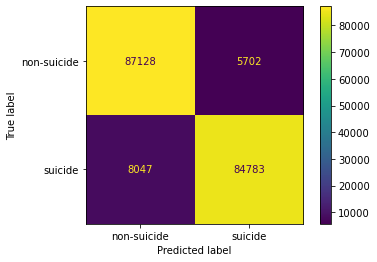

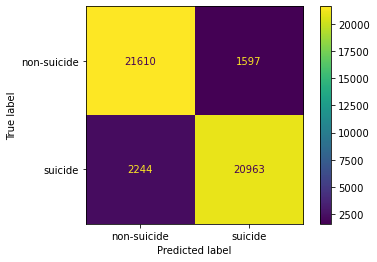

In [62]:
print('For Entire Dataset (TFIDF - unigrams)')
print("Logistic Regression L1 regularization (C = 1) tfidf vectorized \n")
train_score, train_plot, test_score, test_plot = model_performance(5, data, targets, tfidf_vectorizer_1, LogisticRegression_L1_c_1)
df_scores['Logistic Regression (L1, C = 1) Training'] = list(train_score)
df_scores['Logistic Regression (L1, C = 1)'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

For Entire Dataset (TFIDF - unigrams)
Support Vector Machine (C = 0.5) tfidf vectorized 

Training
Average score of 5 folds : 
	 Precision: 	 0.944 
	 Recall: 	 0.924 
	 F-1 Score: 	 0.934 


Testing
Average score of 5 folds : 
	 Precision: 	 0.932 
	 Recall: 	 0.907 
	 F-1 Score: 	 0.919 



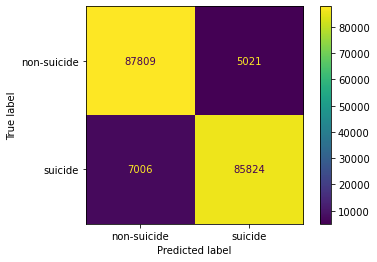

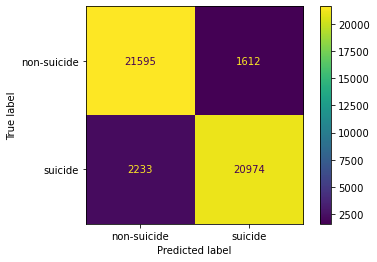

In [63]:
print('For Entire Dataset (TFIDF - unigrams)')
print("Support Vector Machine (C = 0.5) tfidf vectorized ")
train_score, train_plot, test_score, test_plot = model_performance(5, data, targets, tfidf_vectorizer_1, svm_05)
df_scores['Support Vector Machine (C = 0.5) Training'] = list(train_score)
df_scores['Support Vector Machine (C = 0.5) Testing'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

For Entire Dataset (TFIDF - unigrams)
Naive Bayes (alpha = 0.1) tfidf vectorized 

Training
Average score of 5 folds : 
	 Precision: 	 0.848 
	 Recall: 	 0.940 
	 F-1 Score: 	 0.892 


Testing
Average score of 5 folds : 
	 Precision: 	 0.836 
	 Recall: 	 0.936 
	 F-1 Score: 	 0.883 



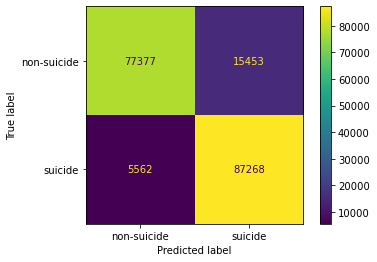

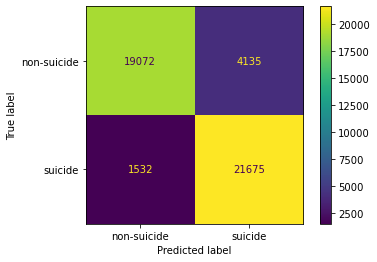

In [65]:
print('For Entire Dataset (TFIDF - unigrams)')
print("Naive Bayes (alpha = 0.1) tfidf vectorized ")
train_score, train_plot, test_score, test_plot = model_performance(5, data, targets, tfidf_vectorizer_1, naive_bayes_01)
df_scores['Naive Bayes (alpha = 0.1) Training'] = list(train_score)
df_scores['Naive Bayes (alpha = 0.1) Testing'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

In [66]:
df_scores

,"Logistic Regression (L1, C = 1) Training","Logistic Regression (L1, C = 1)",Support Vector Machine (C = 0.5) Training,Support Vector Machine (C = 0.5) Testing,Naive Bayes (alpha = 0.1) Training,Naive Bayes (alpha = 0.1) Testing
Precision,0.936880,0.931541,0.943770,0.931763,0.847613,0.836005
Recall,0.912125,0.905883,0.923524,0.906797,0.940424,0.935529
F1 Score,0.924337,0.918533,0.933538,0.919110,0.891606,0.882969


### Tokens

In [67]:
# get the probabilities of each token given that the email is spam and ham
p_risk = naive_bayes_01.feature_log_prob_[0, :]
p_no_risk = naive_bayes_01.feature_log_prob_[1, :]

# calculate the log-ratio of the probabilities for each token
log_ratio = np.log(p_risk / p_no_risk)

# get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer_1.get_feature_names_out()

# sort the tokens based on the log-ratio in descending order
sorted_indices = np.argsort(log_ratio)[::-1]

# print the 10 most indicative tokens for the spam class
for i in range(10):
    token_index = sorted_indices[i]
    token_log_ratio = log_ratio[token_index]
    token_name = feature_names[token_index]
    print(f"{i+1}. {token_name} ({token_log_ratio:.2f})")

1. euthanasia (0.40)
2. suicide (0.40)
3. retarded (0.37)
4. suicidal (0.37)
5. aspirin (0.36)
6. inpatient (0.36)
7. devastate (0.35)
8. overdose (0.34)
9. burden (0.34)
10. ideation (0.34)


## Bigrams 

In [11]:
LogisticRegression_L1_c_5=LogisticRegression(penalty='l1', C = 5, solver='saga', max_iter=1000)
svm_1 = LinearSVC(C=1, dual=True) #n_samples < n_features
naive_bayes_001 = MultinomialNB(alpha=0.01)

In [12]:
df_scores = pd.DataFrame(index=['Precision', 'Recall', 'F1 Score'])

In [13]:
print('For Entire Dataset (TFIDF - bigrams)')
print("Logistic Regression L1 regularization (C = 5) tfidf vectorized \n")
train_score, train_plot, test_score, test_plot = model_performance(5, data, targets, tfidf_vectorizer_2, LogisticRegression_L1_c_5)
df_scores['Logistic Regression (L1, C = 5) Training'] = list(train_score)
df_scores['Logistic Regression (L1, C = 5)'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

For Entire Dataset (TFIDF - bigrams)
Logistic Regression L1 regularization (C = 5) tfidf vectorized 



NameError: name 'model_performance' is not defined

For Entire Dataset (TFIDF - bigrams)
Support Vector Machine (C = 1) tfidf vectorized 

Training
Average score of 5 folds : 
	 Precision: 	 0.994 
	 Recall: 	 0.993 
	 F-1 Score: 	 0.993 


Testing
Average score of 5 folds : 
	 Precision: 	 0.928 
	 Recall: 	 0.919 
	 F-1 Score: 	 0.923 



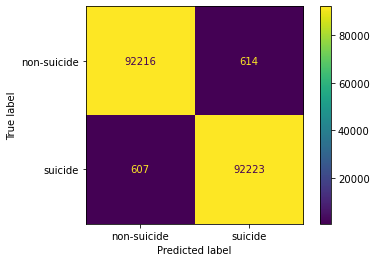

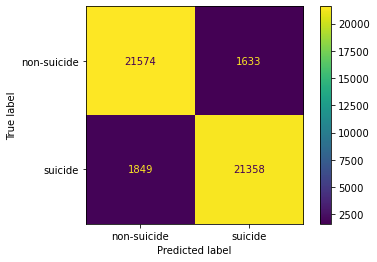

In [20]:
print('For Entire Dataset (TFIDF - bigrams)')
print("Support Vector Machine (C = 1) tfidf vectorized ")
train_score, train_plot, test_score, test_plot = model_performance(5, data, targets, tfidf_vectorizer_2, svm_1)
df_scores['Support Vector Machine (C = 1) Training'] = list(train_score)
df_scores['Support Vector Machine (C = 1) Testing'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

For Entire Dataset (TFIDF - bigrams)
Naive Bayes (alpha = 0.01) tfidf vectorized 

Training
Average score of 5 folds : 
	 Precision: 	 0.968 
	 Recall: 	 0.991 
	 F-1 Score: 	 0.979 


Testing
Average score of 5 folds : 
	 Precision: 	 0.793 
	 Recall: 	 0.968 
	 F-1 Score: 	 0.872 



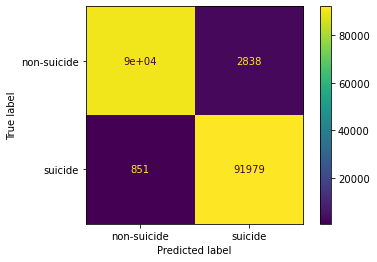

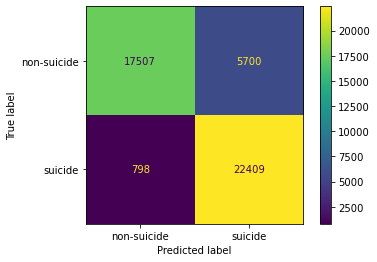

In [20]:
print('For Entire Dataset (TFIDF - bigrams)')
print("Naive Bayes (alpha = 0.01) tfidf vectorized ")
train_score, train_plot, test_score, test_plot = model_performance(5, data, targets, tfidf_vectorizer_2, naive_bayes_001)
df_scores['Naive Bayes (alpha = 0.01) Training'] = list(train_score)
df_scores['Naive Bayes (alpha = 0.01) Testing'] = list(test_score)

print('\nTraining')
display_score(train_score)
train_plot.plot()

print('\nTesting')
display_score(test_score)
test_plot.plot();

In [ ]:
df_scores

### Tokens

In [21]:
# get the probabilities of each token given that the email is spam and ham
p_risk = naive_bayes_001.feature_log_prob_[0, :]
p_no_risk = naive_bayes_001.feature_log_prob_[1, :]

# calculate the log-ratio of the probabilities for each token
log_ratio = np.log(p_risk / p_no_risk)

# get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer_2.get_feature_names_out()

# sort the tokens based on the log-ratio in descending order
sorted_indices = np.argsort(log_ratio)[::-1]

# print the 10 most indicative tokens for the spam class
for i in range(10):
    token_index = sorted_indices[i]
    token_log_ratio = log_ratio[token_index]
    token_name = feature_names[token_index]
    print(f"{i+1}. {token_name} ({token_log_ratio:.2f})")

1. tried therapy (0.51)
2. suicide think (0.50)
3. chronic pain (0.50)
4. wrote suicide (0.49)
5. point alive (0.49)
6. hold job (0.49)
7. end everything (0.49)
8. job feel (0.47)
9. suicidal time (0.47)
10. decent job (0.46)


## Ensemble Learning

In [22]:
from sklearn.ensemble import VotingClassifier

In [23]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_1, targets, test_size=0.2, random_state=22)

In [26]:
classifier_1 = LogisticRegression_L1_c_1
classifier_2 = svm_05
classifier_3 = naive_bayes_01

ensemble = VotingClassifier(estimators=[('Logistic Regression', classifier_1), ('SVM', classifier_2), ('Naïve Bayes', classifier_3)])

In [27]:
names = ['Logistic Regression (C = 1)', 'Support Vector Machines (C = 0.5)', 'Naïve Bayes (alpha = 0.1)', 'Ensemble (Hard Voting)']
classifiers = [classifier_1, classifier_2, classifier_3, ensemble]

for clf, name in zip(classifiers, names):
    train_scores = cross_val_score(clf, X_train, y_train, cv=5)
    test_scores = cross_val_score(clf, X_test, y_test, cv=5)
    print(f'Accuracy: {train_scores.mean():.3f}(+/- {train_scores.std():.3f})[{name}]')
    print(f'Accuracy: {test_scores.mean():.3f}(+/- {test_scores.std():.3f})[{name}]')

Accuracy: 0.919(+/- 0.002)[Logistic Regression (C = 1)]
Accuracy: 0.919(+/- 0.002)[Support Vector Machines (C = 0.5)]
Accuracy: 0.877(+/- 0.002)[Naïve Bayes (alpha = 0.1)]
Accuracy: 0.920(+/- 0.002)[Ensemble (Hard Voting)]
